In [12]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import gridspec
import matplotlib
import cartopy as cart
from scipy import stats

# Load Variables

In [2]:
omega_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_wap_37model_piControl_2x2_last250.nc')
omega_cont.load()

omega_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_wap_34model_historical_2x2_last250.nc')
omega_hist.load()

tas_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_tas_piControl_2x2_48mod_last250.nc')
tas_cont.load()

tas_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_tas_43mod_historical_2x2.nc')
tas_hist.load()

ts_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_ts_39model_piControl_2x2_last250.nc')
ts_cont.load()

ts_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_ts_38model_historical_2x2.nc')
ts_hist.load()

land_mask = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_landmask_31model.nc')
land_mask.load()

<xarray.DataArray 'sftlf' (name: 31, lat: 88, lon: 179)>
array([[[100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [ 99.99997711,  99.99997711,  99.99998665, ..., 100.        ,
         100.        ,  99.99999809],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[         nan, 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [         nan, 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [         nan, 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
...
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
    type     |S4 b'land'
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'GFDL-CM4' 'GISS-E2-1-H' ... 'EC-Earth3-AerChem'
Attributes:
    cell_measures:    area: areacella
    cell_methods:     area: mean
    interp_method:    conserve_order1
    long_name:        Land Area Fraction
    ocean_fillvalue:  0.0
    original_name:    sftlf
    standard_name:    land_area_fraction
    units:            %

In [2]:
omega_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_wap_37model_piControl_2x2_last250.nc')
#omega_cont.load()

omega_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_wap_34model_historical_2x2_last250.nc')
#omega_hist.load()

In [3]:
# Selecting models to be used

models = ['ACCESS-CM2','ACCESS-ESM1-5','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2','CESM2-WACCM',
          'CESM2-WACCM-FV2','CIESM','CMCC-CM2-SR5','CMCC-ESM2','EC-Earth3','EC-Earth3-AerChem','EC-Earth3-CC',
          'EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','INM-CM4-8','INM-CM5-0',
          'IPSL-CM5A2-INCA','MIROC6','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-LM','NorESM2-MM','SAM0-UNICON',
          'TaiESM1']

omega_cont_trunc = omega_cont.sel(name=models)

omega_hist_trunc = omega_hist.sel(name=models)

#tas_cont_trunc = tas_cont.sel(name=models)

#tas_hist_trunc = tas_hist.sel(name=models)

#ts_cont_trunc = ts_cont.sel(name=models)

#ts_hist_trunc = ts_hist.sel(name=models)

# Variability

In [4]:
# Calculating variability

ts_cont_rolling = ts_cont_trunc.rolling(time=120, center=True).mean('time')
ts_cont_std = ts_cont_rolling.std('time')
ts_cont_var = ts_cont_std.mean('name')
ts_cont_var

ts_hist_rolling = ts_hist_trunc.rolling(time=120, center=True).mean('time')
ts_hist_std = ts_hist_rolling.std('time')
ts_hist_var = ts_hist_std.mean('name')
ts_hist_var

tas_cont_rolling = tas_cont_trunc.rolling(time=120, center=True).mean('time')
tas_cont_std = tas_cont_rolling.std('time')
tas_cont_var = tas_cont_std.mean('name')
tas_cont_var

tas_hist_rolling = tas_hist_trunc.rolling(time=120, center=True).mean('time')
tas_hist_std = tas_hist_rolling.std('time')
tas_hist_var = tas_hist_std.mean('name')
tas_hist_var


ts_diff_var = ts_hist_var - ts_cont_var
ts_percent_var = ts_diff_var*100/ts_cont_var

tas_diff_var = tas_hist_var - tas_cont_var
tas_percent_var = tas_diff_var*100/tas_cont_var

In [4]:
# Selecting last 30 years, taking time and name means

omega_cont_mean = omega_cont_trunc.isel(time=slice(len(omega_cont.time)-(30*12),len(omega_cont.time))).mean('time').mean('name')

omega_hist_mean = omega_hist_trunc.isel(time=slice(len(omega_hist.time)-(30*12),len(omega_hist.time))).mean('time').mean('name')

In [6]:
# Saving unmasked omega data

omega_cont_mean.to_netcdf('../processed_data/paper1/fig_1_omega_cont_nonmasked.nc')

omega_hist_mean.to_netcdf('../processed_data/paper1/fig_1_omega_hist_nonmasked.nc')

In [6]:
# Creating mask

mask = land_mask.mean('name')

In [8]:
# Removing poles, masking

omega_cont_mask = omega_cont_mean.where(mask<50).sel(lat=slice(-60,60))
omega_hist_mask = omega_hist_mean.where(mask<50).sel(lat=slice(-60,60))

ts_cont_mask = ts_cont_var.where(mask<50).sel(lat=slice(-60,60))
ts_hist_mask = ts_hist_var.where(mask<50).sel(lat=slice(-60,60))
ts_percent_mask = ts_percent_var.where(mask<50).sel(lat=slice(-60,60))

In [10]:
# Saving masked data

omega_cont_mask.to_netcdf('../processed_data/paper1/fig_1_omega_cont.nc')
omega_hist_mask.to_netcdf('../processed_data/paper1/fig_1_omega_hist.nc')

ts_cont_mask.to_netcdf('../processed_data/paper1/fig_1_ts_cont.nc')
ts_hist_mask.to_netcdf('../processed_data/paper1/fig_1_ts_hist.nc')
ts_percent_mask.to_netcdf('../processed_data/paper1/fig_1_ts_percent.nc')

In [11]:
# Saving masked tas data

tas_cont_var.to_netcdf('../processed_data/paper1/fig_1_tas_cont.nc')
tas_hist_var.to_netcdf('../processed_data/paper1/fig_1_tas_hist.nc')
tas_percent_var.to_netcdf('../processed_data/paper1/fig_1_tas_percent.nc')

# Correlation

In [2]:
# Forced signal

cmip6_ts_forced = xr.open_dataarray('/data/keeling/a/mailes2/a/lens_processed/CMIP6_TS_forced.nc')
cmip6_ts_forced.load()

<xarray.DataArray 'ts' (name: 17, time: 1980, lat: 88, lon: 179)>
array([[[[252.93326359, 252.90495923, 252.80650798, ..., 253.13923722,
          253.06408895, 253.01630444],
         [254.15332804, 254.00489502, 253.80661011, ..., 254.81757975,
          254.6388855 , 254.48421021],
         [255.19233488, 254.99065063, 254.74355184, ..., 256.09888647,
          255.92413208, 255.69287744],
         ...,
         [240.24013403, 240.41900049, 240.56945475, ..., 239.37192082,
          239.68867716, 239.89691772],
         [238.89970215, 238.97022949, 239.02863159, ..., 238.46505819,
          238.58042196, 238.65355225],
         [237.96138029, 237.99948389, 238.04493896, ..., 237.84892253,
          237.88185628, 237.886927  ]],

        [[235.00957853, 234.90165527, 234.76960205, ..., 235.77287671,
          235.58107747, 235.40388843],
         [238.21958008, 237.92688232, 237.64275513, ..., 239.52232463,
          239.13252767, 238.81321899],
         [240.73312174, 240.38709888, 240.04714315, ..., 242.27521997,
          241.90663493, 241.54754639],
...
         [243.66384878, 244.00824577, 244.27320993, ..., 242.28782835,
          242.63364961, 242.97783968],
         [241.74909776, 241.88676658, 242.01306042, ..., 241.18296474,
          241.31160647, 241.46796288],
         [240.76856356, 240.81903994, 240.86411654, ..., 240.51214213,
          240.57545166, 240.64138753]],

        [[242.4835041 , 242.28104365, 242.09757818, ..., 243.35647598,
          243.11698837, 242.91836929],
         [246.08997558, 245.45429634, 244.8071042 , ..., 248.10194684,
          247.6193359 , 247.09207247],
         [248.1952831 , 247.44631005, 246.88653887, ..., 250.86446855,
          251.04786479, 250.24355191],
         ...,
         [243.33835937, 243.68369776, 243.93520156, ..., 241.57934207,
          242.06947628, 242.53547932],
         [241.20464893, 241.41959518, 241.60680991, ..., 240.22217249,
          240.44758966, 240.72438145],
         [239.9006017 , 240.0058637 , 240.10053533, ..., 239.39759827,
          239.51933899, 239.64630025]]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'NorCPM1'

In [3]:
# Original 17 model, 10 member ensemble

cmip6_ts = xr.open_dataarray('/data/keeling/a/mailes2/a/lens_processed/CMIP6_TS_17mod_10mem.nc')

In [4]:
# Rolling means

cmip6_ts_smoothed = cmip6_ts.rolling(time=120, center=True).mean('time')
cmip6_ts_forced_smoothed = cmip6_ts_forced.rolling(time=120, center=True).mean('time')

In [5]:
# Correlation

cmip6_ts_global_corr = xr.DataArray(np.zeros((17,10,88,179)), dims=['name','version','lat','lon'])
i = 0
for model in cmip6_ts_smoothed['name']:
    print(model)
    cmip6_ts_global_corr[i,:,:,:] = xr.corr(cmip6_ts_smoothed.sel(name=model), 
                                        cmip6_ts_forced_smoothed.sel(name=model).mean('lat').mean('lon'), dim='time')
    i += 1
cmip6_ts_global_corr

<xarray.DataArray 'name' ()>
array('ACCESS-CM2', dtype='<U10')
Coordinates:
    name     <U10 'ACCESS-CM2'
<xarray.DataArray 'name' ()>
array('ACCESS-ESM1-5', dtype='<U13')
Coordinates:
    name     <U13 'ACCESS-ESM1-5'
<xarray.DataArray 'name' ()>
array('CNRM-CM6-1', dtype='<U10')
Coordinates:
    name     <U10 'CNRM-CM6-1'
<xarray.DataArray 'name' ()>
array('CNRM-ESM2-1', dtype='<U11')
Coordinates:
    name     <U11 'CNRM-ESM2-1'
<xarray.DataArray 'name' ()>
array('CanESM5-1', dtype='<U9')
Coordinates:
    name     <U9 'CanESM5-1'
<xarray.DataArray 'name' ()>
array('CanESM5', dtype='<U7')
Coordinates:
    name     <U7 'CanESM5'
<xarray.DataArray 'name' ()>
array('E3SM-2-0', dtype='<U8')
Coordinates:
    name     <U8 'E3SM-2-0'
<xarray.DataArray 'name' ()>
array('GISS-E2-1-G', dtype='<U11')
Coordinates:
    name     <U11 'GISS-E2-1-G'
<xarray.DataArray 'name' ()>
array('GISS-E2-1-H', dtype='<U11')
Coordinates:
    name     <U11 'GISS-E2-1-H'
<xarray.DataArray 'name' ()>
array('INM-CM5

<xarray.DataArray (name: 17, version: 10, lat: 88, lon: 179)>
array([[[[0.80176175, 0.80352768, 0.80312946, ..., 0.80205748,
          0.80123078, 0.80284219],
         [0.73747482, 0.73530059, 0.73323651, ..., 0.7376856 ,
          0.73780885, 0.73795871],
         [0.71760417, 0.71610721, 0.71080375, ..., 0.73086777,
          0.72998587, 0.7246827 ],
         ...,
         [0.75439628, 0.74928961, 0.74427233, ..., 0.77959387,
          0.76923376, 0.7636526 ],
         [0.7992725 , 0.79740222, 0.79548274, ..., 0.80344062,
          0.80202096, 0.80123558],
         [0.80671995, 0.80593438, 0.80571103, ..., 0.81092082,
          0.80981917, 0.80845974]],

        [[0.74712794, 0.74758212, 0.74601769, ..., 0.75463357,
          0.75363971, 0.75263044],
         [0.70441477, 0.7023875 , 0.70019875, ..., 0.70102143,
          0.70085316, 0.70310346],
         [0.72680904, 0.72866618, 0.72850929, ..., 0.72803519,
          0.72739467, 0.72655871],
...
         [0.60102711, 0.58358614, 0.57023057, ..., 0.68445874,
          0.66076265, 0.63952874],
         [0.6833707 , 0.67586299, 0.66871124, ..., 0.71885483,
          0.710142  , 0.69998164],
         [0.71322241, 0.71037674, 0.70797351, ..., 0.72761524,
          0.72391641, 0.72025985]],

        [[0.86665029, 0.85366337, 0.85757789, ..., 0.86970077,
          0.85645895, 0.83867369],
         [0.81783478, 0.83085452, 0.83092088, ..., 0.80972566,
          0.80097074, 0.79189412],
         [0.75153936, 0.7768034 , 0.78498783, ..., 0.72697162,
          0.75952145, 0.72673477],
         ...,
         [0.55175794, 0.51846124, 0.49190848, ..., 0.67808418,
          0.64768391, 0.61848454],
         [0.62671044, 0.61261738, 0.59935191, ..., 0.68406706,
          0.67117375, 0.65592359],
         [0.65934643, 0.65329482, 0.64857351, ..., 0.68204814,
          0.67657232, 0.67133574]]]])
Dimensions without coordinates: name, version, lat, lon

In [6]:
# Dataset setup

cmip6_ts_global_corr_mean = cmip6_ts_global_corr.mean('version').mean('name')

#cmip6_ts_global_corr_mean.coords['name'] = cmip6_ts_smoothed['name'].values
cmip6_ts_global_corr_mean.coords['lat'] = cmip6_ts_smoothed['lat'].values
cmip6_ts_global_corr_mean.coords['lon'] = cmip6_ts_smoothed['lon'].values
cmip6_ts_global_corr_mean

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.6786852 , 0.69220174, 0.692047  , ..., 0.69553116, 0.69636372,
        0.69632517],
       [0.65598908, 0.67048458, 0.67008197, ..., 0.66637277, 0.66731574,
        0.6705353 ],
       [0.64306259, 0.65779293, 0.65654774, ..., 0.6590861 , 0.65765987,
        0.65787799],
       ...,
       [0.70053564, 0.71177232, 0.70376606, ..., 0.75521212, 0.74791507,
        0.73705382],
       [0.73023645, 0.74428081, 0.73983777, ..., 0.76664037, 0.76239793,
        0.7563533 ],
       [0.75305329, 0.7673909 , 0.76534906, ..., 0.77716468, 0.77521055,
        0.77331808]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [7]:
# Removing poles

cmip6_ts_global_corr_trunc = cmip6_ts_global_corr_mean.sel(lat=slice(-60,60))

In [9]:
# Saving dataset

cmip6_ts_global_corr_trunc.to_netcdf('../processed_data/paper1/fig_1_tscorr.nc')

# Plotting

In [2]:
omega_cont_mask = xr.open_dataarray('../processed_data/paper1/fig_1_omega_cont.nc')
omega_cont_mask.load()
omega_hist_mask = xr.open_dataarray('../processed_data/paper1/fig_1_omega_hist.nc')
omega_hist_mask.load()

ts_cont_mask = xr.open_dataarray('../processed_data/paper1/fig_1_ts_cont.nc')
ts_cont_mask.load()
ts_hist_mask = xr.open_dataarray('../processed_data/paper1/fig_1_ts_hist.nc')
ts_hist_mask.load()
ts_percent_mask = xr.open_dataarray('../processed_data/paper1/fig_1_ts_percent.nc')
ts_percent_mask.load()

# Saving unmasked omega data

omega_cont_mean = xr.open_dataarray('../processed_data/paper1/fig_1_omega_cont_nonmasked.nc')
omega_cont_mean.load()
omega_cont_mean = omega_cont_mean.sel(lat=slice(-60,60))
omega_hist_mean = xr.open_dataarray('../processed_data/paper1/fig_1_omega_hist_nonmasked.nc')
omega_hist_mean.load()
omega_hist_mean = omega_hist_mean.sel(lat=slice(-60,60))

tas_cont_var = xr.open_dataarray('../processed_data/paper1/fig_1_tas_cont.nc')
tas_cont_var.load()
tas_cont_var = tas_cont_var.sel(lat=slice(-60,60))
tas_hist_var = xr.open_dataarray('../processed_data/paper1/fig_1_tas_hist.nc')
tas_hist_var.load()
tas_hist_var = tas_hist_var.sel(lat=slice(-60,60))
tas_percent_var = xr.open_dataarray('../processed_data/paper1/fig_1_tas_percent.nc')
tas_percent_var.load()
tas_percent_var = tas_percent_var.sel(lat=slice(-60,60))

cmip6_ts_global_corr_mean = xr.open_dataarray('../processed_data/paper1/fig_1_tscorr.nc')
cmip6_ts_global_corr_mean.load()

<xarray.DataArray (lat: 60, lon: 179)>
array([[0.47060025, 0.47658793, 0.47427238, ..., 0.50197715, 0.49594269,
        0.49112388],
       [0.47641685, 0.48212332, 0.47343975, ..., 0.52463272, 0.51939842,
        0.51236775],
       [0.50545108, 0.5128964 , 0.50354918, ..., 0.51478845, 0.52140291,
        0.5257155 ],
       ...,
       [0.61575948, 0.60781791, 0.59971408, ..., 0.57979173, 0.61531735,
        0.6310492 ],
       [0.59871884, 0.59654955, 0.59173451, ..., 0.55006575, 0.61419635,
        0.61986823],
       [0.57791003, 0.5872645 , 0.58857669, ..., 0.5366219 , 0.56599671,
        0.57601114]])
Coordinates:
  * lat      (lat) int64 -59 -57 -55 -53 -51 -49 -47 ... 47 49 51 53 55 57 59
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

10740


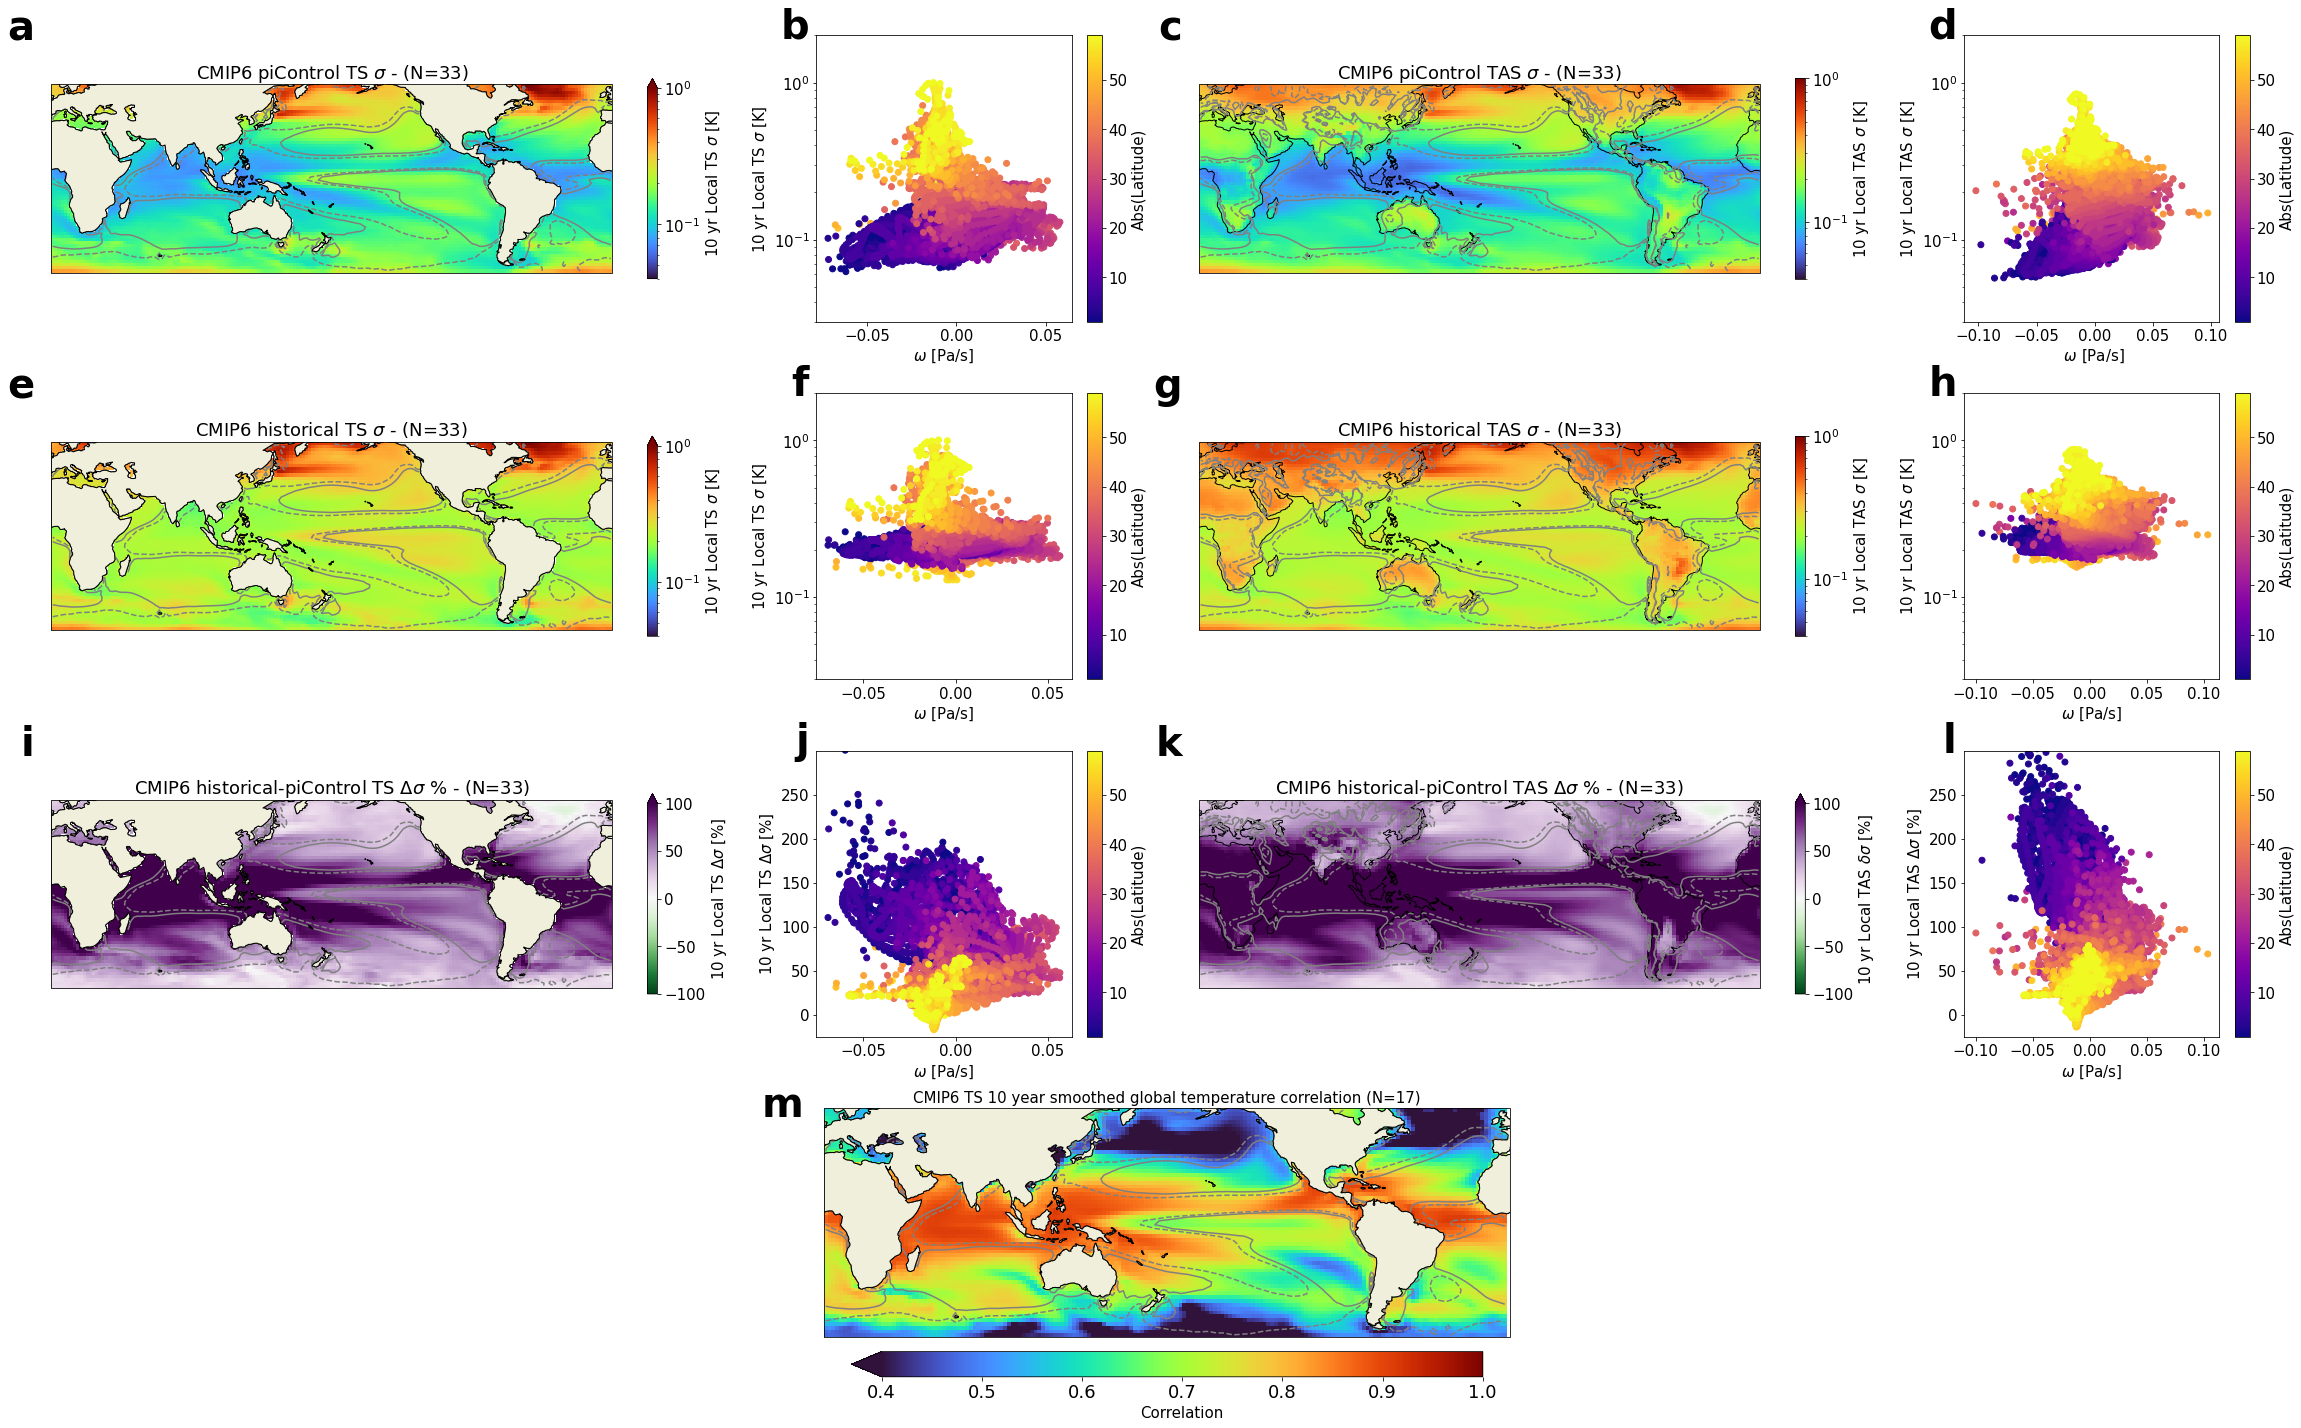

In [42]:
colored_lats = []
for latitude in ts_percent_mask['lat'].values:
    for i in range(179): #length of longitude
       colored_lats.append(abs(latitude))
print(len(colored_lats))


fig = plt.figure(figsize=(40,25))
gs = gridspec.GridSpec(ncols=6, nrows=4)
gs.update(wspace=0.2,hspace=0.25)
#top=300
#bottom=270
font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

ax1 = fig.add_subplot(gs[0,0:2], projection=ccrs.PlateCarree(central_longitude=180))
# https://stackoverflow.com/questions/36525825/mask-ocean-or-land-from-data-using-cartopy
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ts_cont_mask.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                  'shrink': 0.7
                                                                  })
ax1.coastlines(color='black', linewidth=1)
omega_cont_mask.plot.contour(ax=ax1, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax1.text(-0.03, 1.4, 'a', transform=ax1.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
ax1.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
plt.title(r'CMIP6 piControl TS $\sigma$ - (N=33)')

ax2 = fig.add_subplot(gs[0,2])
scatter_cont_ts = ax2.scatter(omega_cont_mask,ts_cont_mask,c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_cont_ts, ax=ax2)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'piControl TS $\sigma$ vs. piControl $\omega$ - (N=33)')
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.ylabel(r'10 yr Local TS $\sigma$ [K]')
ax2.text(-0.03, 1.1, 'b', transform=ax2.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')

ax3 = fig.add_subplot(gs[0,3:5], projection=ccrs.PlateCarree(central_longitude=180))
# https://stackoverflow.com/questions/36525825/mask-ocean-or-land-from-data-using-cartopy
#ax3.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_cont_var.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  'shrink': 0.7
                                                                  })
ax3.coastlines(color='black', linewidth=1)
omega_cont_mean.plot.contour(ax=ax3, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax3.text(-0.03, 1.4, 'c', transform=ax3.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
plt.title(r'CMIP6 piControl TAS $\sigma$ - (N=33)')

ax4 = fig.add_subplot(gs[0,5])
scatter_cont_tas = ax4.scatter(omega_cont_mean,tas_cont_var,c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_cont_tas, ax=ax4)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'piControl TAS $\sigma$ vs. piControl $\omega$ - (N=33)')
plt.xlabel(r' $\omega$ [Pa/s]')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.ylabel(r'10 yr Local TAS $\sigma$ [K]')
ax4.text(-0.03, 1.1, 'd', transform=ax4.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')


ax5 = fig.add_subplot(gs[1,0:2], projection=ccrs.PlateCarree(central_longitude=180))
ts_hist_mask.plot(ax=ax5, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                  'shrink': 0.7
                                                                  })
#ax5.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax5.coastlines(color='black', linewidth=1)
omega_hist_mask.plot.contour(ax=ax5, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical TS $\sigma$ - (N=33)')
ax5.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
ax5.text(-0.03, 1.4, 'e', transform=ax5.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')

ax6 = fig.add_subplot(gs[1,2])
scatter_hist_ts = ax6.scatter(omega_hist_mask,ts_hist_mask,c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_hist_ts, ax=ax6)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'historical TS $\sigma$ vs. historical $\omega$ - (N=33)')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TS $\sigma$ [K]')
ax6.text(-0.03, 1.1, 'f', transform=ax6.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')

ax7 = fig.add_subplot(gs[1,3:5], projection=ccrs.PlateCarree(central_longitude=180))
tas_hist_var.plot(ax=ax7, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  'shrink': 0.7
                                                                  })
#ax7.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax7.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax7, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical TAS $\sigma$ - (N=33)')
ax7.text(-0.03, 1.4, 'g', transform=ax7.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')

ax8 = fig.add_subplot(gs[1,5])
scatter_hist_tas = ax8.scatter(omega_hist_mean,tas_hist_var,c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_hist_tas, ax=ax8)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'historical TAS $\sigma$ vs. historical $\omega$ - (N=33)')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TAS $\sigma$ [K]')
ax8.text(-0.03, 1.1, 'h', transform=ax8.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')

ax9 = fig.add_subplot(gs[2,0:2], projection=ccrs.PlateCarree(central_longitude=180))
ts_percent_mask.plot(ax=ax9, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-100, vmax=100, 
                    cbar_kwargs={'label': r"10 yr Local TS $\Delta \sigma$ [%]",
                                 'shrink': 0.7
                                 })
#ax9.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax9.coastlines(color='black', linewidth=1)
omega_hist_mask.plot.contour(ax=ax9, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical-piControl TS $\Delta \sigma$ % - (N=33)')
ax9.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
ax9.text(-0.03, 1.4, 'i', transform=ax9.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')

ax10 = fig.add_subplot(gs[2,2])
scatter_percent_ts = ax10.scatter(omega_hist_mask, ts_percent_mask, c=colored_lats, cmap='plasma')
cbar = plt.colorbar(scatter_percent_ts, ax=ax10)
cbar.ax.set_ylabel('Abs(Latitude)')
plt.ylim(-25,300)
#plt.title('historical-piControl TS $\Delta \sigma$ % vs. historical $\omega$ - (N=33)', fontsize=30)
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TS $\Delta \sigma$ [%]')
ax10.text(-0.03, 1.1, 'j', transform=ax10.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
ax10.set_yticks([0,50,100,150,200,250])

ax11 = fig.add_subplot(gs[2,3:5], projection=ccrs.PlateCarree(central_longitude=180))
tas_percent_var.plot(ax=ax11, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-100, vmax=100,
                     cbar_kwargs={'label': r"10 yr Local TAS $\delta \sigma$ [%]",
                                  'shrink': 0.7
                                  })
#ax11.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax11.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax11, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical-piControl TAS $\Delta \sigma$ % - (N=33)')
ax11.text(-0.03, 1.4, 'k', transform=ax11.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')

ax12 = fig.add_subplot(gs[2,5])
scatter_percent_tas = ax12.scatter(omega_hist_mean, tas_percent_var, c=colored_lats, cmap='plasma')
cbar = plt.colorbar(scatter_percent_tas, ax=ax12)
cbar.ax.set_ylabel('Abs(Latitude)')
plt.ylim(-25,300)
#plt.title('historical-piControl TAS $\Delta \sigma$ % vs. historical $\omega$ - (N=33)', fontsize=30)
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TAS $\Delta \sigma$ [%]')
ax12.text(-0.03, 1.1, 'l', transform=ax12.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
ax12.set_yticks([0,50,100,150,200,250])

ax13 = fig.add_subplot(gs[3,2:4], projection=ccrs.PlateCarree(central_longitude=180))
globb = cmip6_ts_global_corr_mean.plot(ax=ax13, transform=ccrs.PlateCarree(), vmin=0.4, vmax=1, cmap='turbo', 
                                                 add_colorbar=False
                                        #cbar_kwargs={'label': 'Correlation',
                                                #     'orientation': 'horizontal',
                                                #     'shrink': 0.9,
                                                #     'pad': 0.05,
                                                #     'aspect': 25}
                                                )
ax13.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax13, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax13.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
plt.title('CMIP6 TS 10 year smoothed global temperature correlation (N=17)', fontsize=15)                                  
cb = plt.colorbar(globb, orientation="horizontal", pad=0.05, aspect=25, shrink=0.9, extend='min')
ax13.set_extent([0,360,-60,60], crs=ccrs.PlateCarree())
ax13.text(-0.03, 1.1, 'm', transform=ax13.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='right')
cb.set_label(label='Correlation', fontsize=15)
cb.ax.tick_params(labelsize='large')

10740


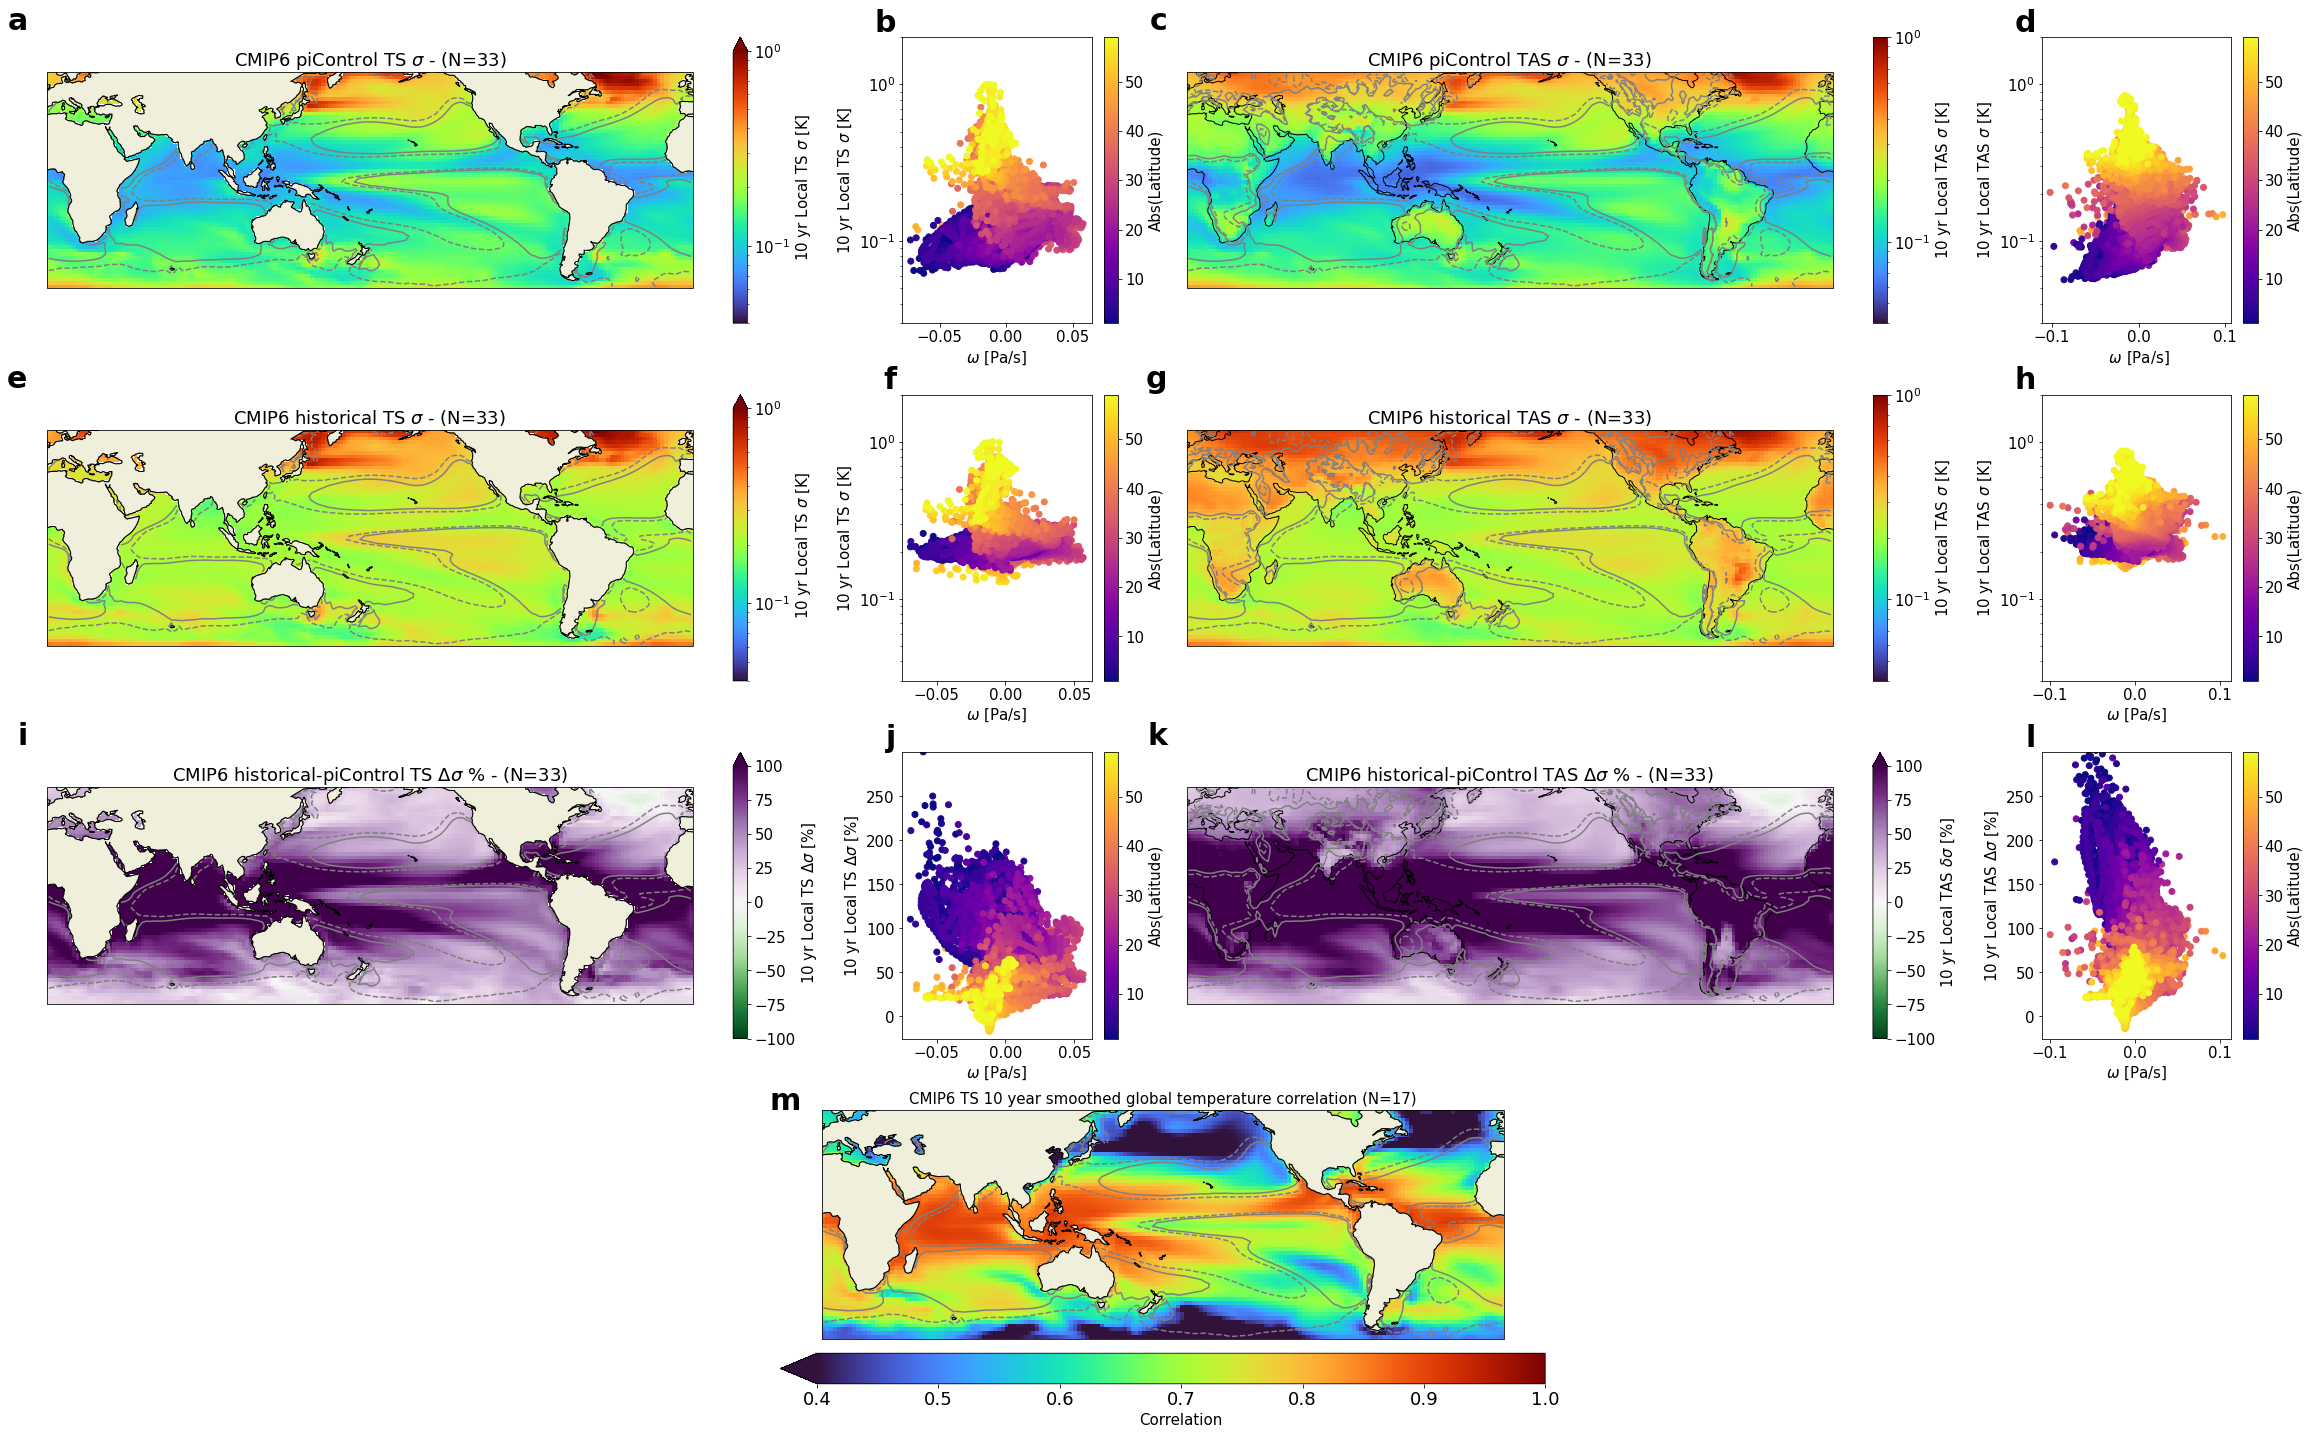

In [13]:
colored_lats = []
for latitude in ts_percent_mask['lat'].values:
    for i in range(179): #length of longitude
       colored_lats.append(abs(latitude))
print(len(colored_lats))


fig = plt.figure(figsize=(40,25))
gs = gridspec.GridSpec(ncols=8, nrows=4)
gs.update(wspace=0.2,hspace=0.25)
#top=300
#bottom=270
font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

ax1 = fig.add_subplot(gs[0,0:3], projection=ccrs.PlateCarree(central_longitude=180))
# https://stackoverflow.com/questions/36525825/mask-ocean-or-land-from-data-using-cartopy
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ts_cont_mask.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                  })
ax1.coastlines(color='black', linewidth=1)
omega_cont_mask.plot.contour(ax=ax1, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax1.text(-0.03, 1.3, 'a', transform=ax1.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
ax1.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
plt.title(r'CMIP6 piControl TS $\sigma$ - (N=33)')

ax2 = fig.add_subplot(gs[0,3])
scatter_cont_ts = ax2.scatter(omega_cont_mask,ts_cont_mask,c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_cont_ts, ax=ax2)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'piControl TS $\sigma$ vs. piControl $\omega$ - (N=33)')
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.ylabel(r'10 yr Local TS $\sigma$ [K]')
ax2.text(-0.03, 1.1, 'b', transform=ax2.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax3 = fig.add_subplot(gs[0,4:7], projection=ccrs.PlateCarree(central_longitude=180))
# https://stackoverflow.com/questions/36525825/mask-ocean-or-land-from-data-using-cartopy
#ax3.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_cont_var.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  })
ax3.coastlines(color='black', linewidth=1)
omega_cont_mean.plot.contour(ax=ax3, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax3.text(-0.03, 1.3, 'c', transform=ax3.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
plt.title(r'CMIP6 piControl TAS $\sigma$ - (N=33)')

ax4 = fig.add_subplot(gs[0,7])
scatter_cont_tas = ax4.scatter(omega_cont_mean,tas_cont_var,c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_cont_tas, ax=ax4)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'piControl TAS $\sigma$ vs. piControl $\omega$ - (N=33)')
plt.xlabel(r' $\omega$ [Pa/s]')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.ylabel(r'10 yr Local TAS $\sigma$ [K]')
ax4.text(-0.03, 1.1, 'd', transform=ax4.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')


ax5 = fig.add_subplot(gs[1,0:3], projection=ccrs.PlateCarree(central_longitude=180))
ts_hist_mask.plot(ax=ax5, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                  })
#ax5.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax5.coastlines(color='black', linewidth=1)
omega_hist_mask.plot.contour(ax=ax5, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical TS $\sigma$ - (N=33)')
ax5.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
ax5.text(-0.03, 1.3, 'e', transform=ax5.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax6 = fig.add_subplot(gs[1,3])
scatter_hist_ts = ax6.scatter(omega_hist_mask,ts_hist_mask,c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_hist_ts, ax=ax6)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'historical TS $\sigma$ vs. historical $\omega$ - (N=33)')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TS $\sigma$ [K]')
ax6.text(-0.03, 1.1, 'f', transform=ax6.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax7 = fig.add_subplot(gs[1,4:7], projection=ccrs.PlateCarree(central_longitude=180))
tas_hist_var.plot(ax=ax7, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  })
#ax7.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax7.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax7, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical TAS $\sigma$ - (N=33)')
ax7.text(-0.03, 1.3, 'g', transform=ax7.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax8 = fig.add_subplot(gs[1,7])
scatter_hist_tas = ax8.scatter(omega_hist_mean,tas_hist_var,c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_hist_tas, ax=ax8)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'historical TAS $\sigma$ vs. historical $\omega$ - (N=33)')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TAS $\sigma$ [K]')
ax8.text(-0.03, 1.1, 'h', transform=ax8.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax9 = fig.add_subplot(gs[2,0:3], projection=ccrs.PlateCarree(central_longitude=180))
ts_percent_mask.plot(ax=ax9, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-100, vmax=100, 
                    cbar_kwargs={'label': r"10 yr Local TS $\Delta \sigma$ [%]",
                                 })
#ax9.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax9.coastlines(color='black', linewidth=1)
omega_hist_mask.plot.contour(ax=ax9, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical-piControl TS $\Delta \sigma$ % - (N=33)')
ax9.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
ax9.text(-0.03, 1.3, 'i', transform=ax9.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax10 = fig.add_subplot(gs[2,3])
scatter_percent_ts = ax10.scatter(omega_hist_mask, ts_percent_mask, c=colored_lats, cmap='plasma')
cbar = plt.colorbar(scatter_percent_ts, ax=ax10)
cbar.ax.set_ylabel('Abs(Latitude)')
plt.ylim(-25,300)
#plt.title('historical-piControl TS $\Delta \sigma$ % vs. historical $\omega$ - (N=33)', fontsize=30)
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TS $\Delta \sigma$ [%]')
ax10.text(-0.03, 1.1, 'j', transform=ax10.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
ax10.set_yticks([0,50,100,150,200,250])

ax11 = fig.add_subplot(gs[2,4:7], projection=ccrs.PlateCarree(central_longitude=180))
tas_percent_var.plot(ax=ax11, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-100, vmax=100,
                     cbar_kwargs={'label': r"10 yr Local TAS $\delta \sigma$ [%]",
                                  })
#ax11.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax11.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax11, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical-piControl TAS $\Delta \sigma$ % - (N=33)')
ax11.text(-0.03, 1.3, 'k', transform=ax11.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax12 = fig.add_subplot(gs[2,7])
scatter_percent_tas = ax12.scatter(omega_hist_mean, tas_percent_var, c=colored_lats, cmap='plasma')
cbar = plt.colorbar(scatter_percent_tas, ax=ax12)
cbar.ax.set_ylabel('Abs(Latitude)')
plt.ylim(-25,300)
#plt.title('historical-piControl TAS $\Delta \sigma$ % vs. historical $\omega$ - (N=33)', fontsize=30)
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TAS $\Delta \sigma$ [%]')
ax12.text(-0.03, 1.1, 'l', transform=ax12.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
ax12.set_yticks([0,50,100,150,200,250])

ax13 = fig.add_subplot(gs[3,2:6], projection=ccrs.PlateCarree(central_longitude=180))
globb = cmip6_ts_global_corr_mean.plot(ax=ax13, transform=ccrs.PlateCarree(), vmin=0.4, vmax=1, cmap='turbo', 
                                                 add_colorbar=False
                                        #cbar_kwargs={'label': 'Correlation',
                                                #     'orientation': 'horizontal',
                                                #     'shrink': 0.9,
                                                #     'pad': 0.05,
                                                #     'aspect': 25}
                                                )
ax13.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax13, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax13.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
plt.title('CMIP6 TS 10 year smoothed global temperature correlation (N=17)', fontsize=15)                                  
cb = plt.colorbar(globb, orientation="horizontal", pad=0.05, aspect=25, shrink=0.7, extend='min')
ax13.set_extent([0,358,-60,60], crs=ccrs.PlateCarree())
ax13.text(-0.03, 1.1, 'm', transform=ax13.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
cb.set_label(label='Correlation', fontsize=15)
cb.ax.tick_params(labelsize='large')

In [55]:
omega_cont_mask

<xarray.DataArray 'wap' (lat: 60, lon: 179)>
array([[-0.00727588, -0.00744083, -0.00774309, ..., -0.00655702,
        -0.00655247, -0.00673955],
       [-0.007288  , -0.00762306, -0.00794416, ..., -0.00702722,
        -0.00710003, -0.00725709],
       [-0.00725159, -0.00749153, -0.00763401, ..., -0.00637254,
        -0.00656798, -0.00689115],
       ...,
       [-0.01314927, -0.0062194 , -0.0063168 , ...,         nan,
                nan,         nan],
       [-0.01311926, -0.0087581 , -0.00964258, ..., -0.01439103,
                nan,         nan],
       [-0.0189826 , -0.02205148, -0.01016029, ..., -0.01835543,
        -0.01405766, -0.02007695]])
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -59 -57 -55 -53 -51 -49 -47 ... 47 49 51 53 55 57 59
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    type     |S4 b'land'

In [66]:
def reverse(array):
    new_array = []
    for latitude in list(reversed(array.sel(lat=slice(0,60))['lat'].values)):
        new_array.append(array.sel(lat=latitude))
        new_array.append(array.sel(lat=-latitude))
    return new_array

In [63]:
colored_lats[0]

59

10740


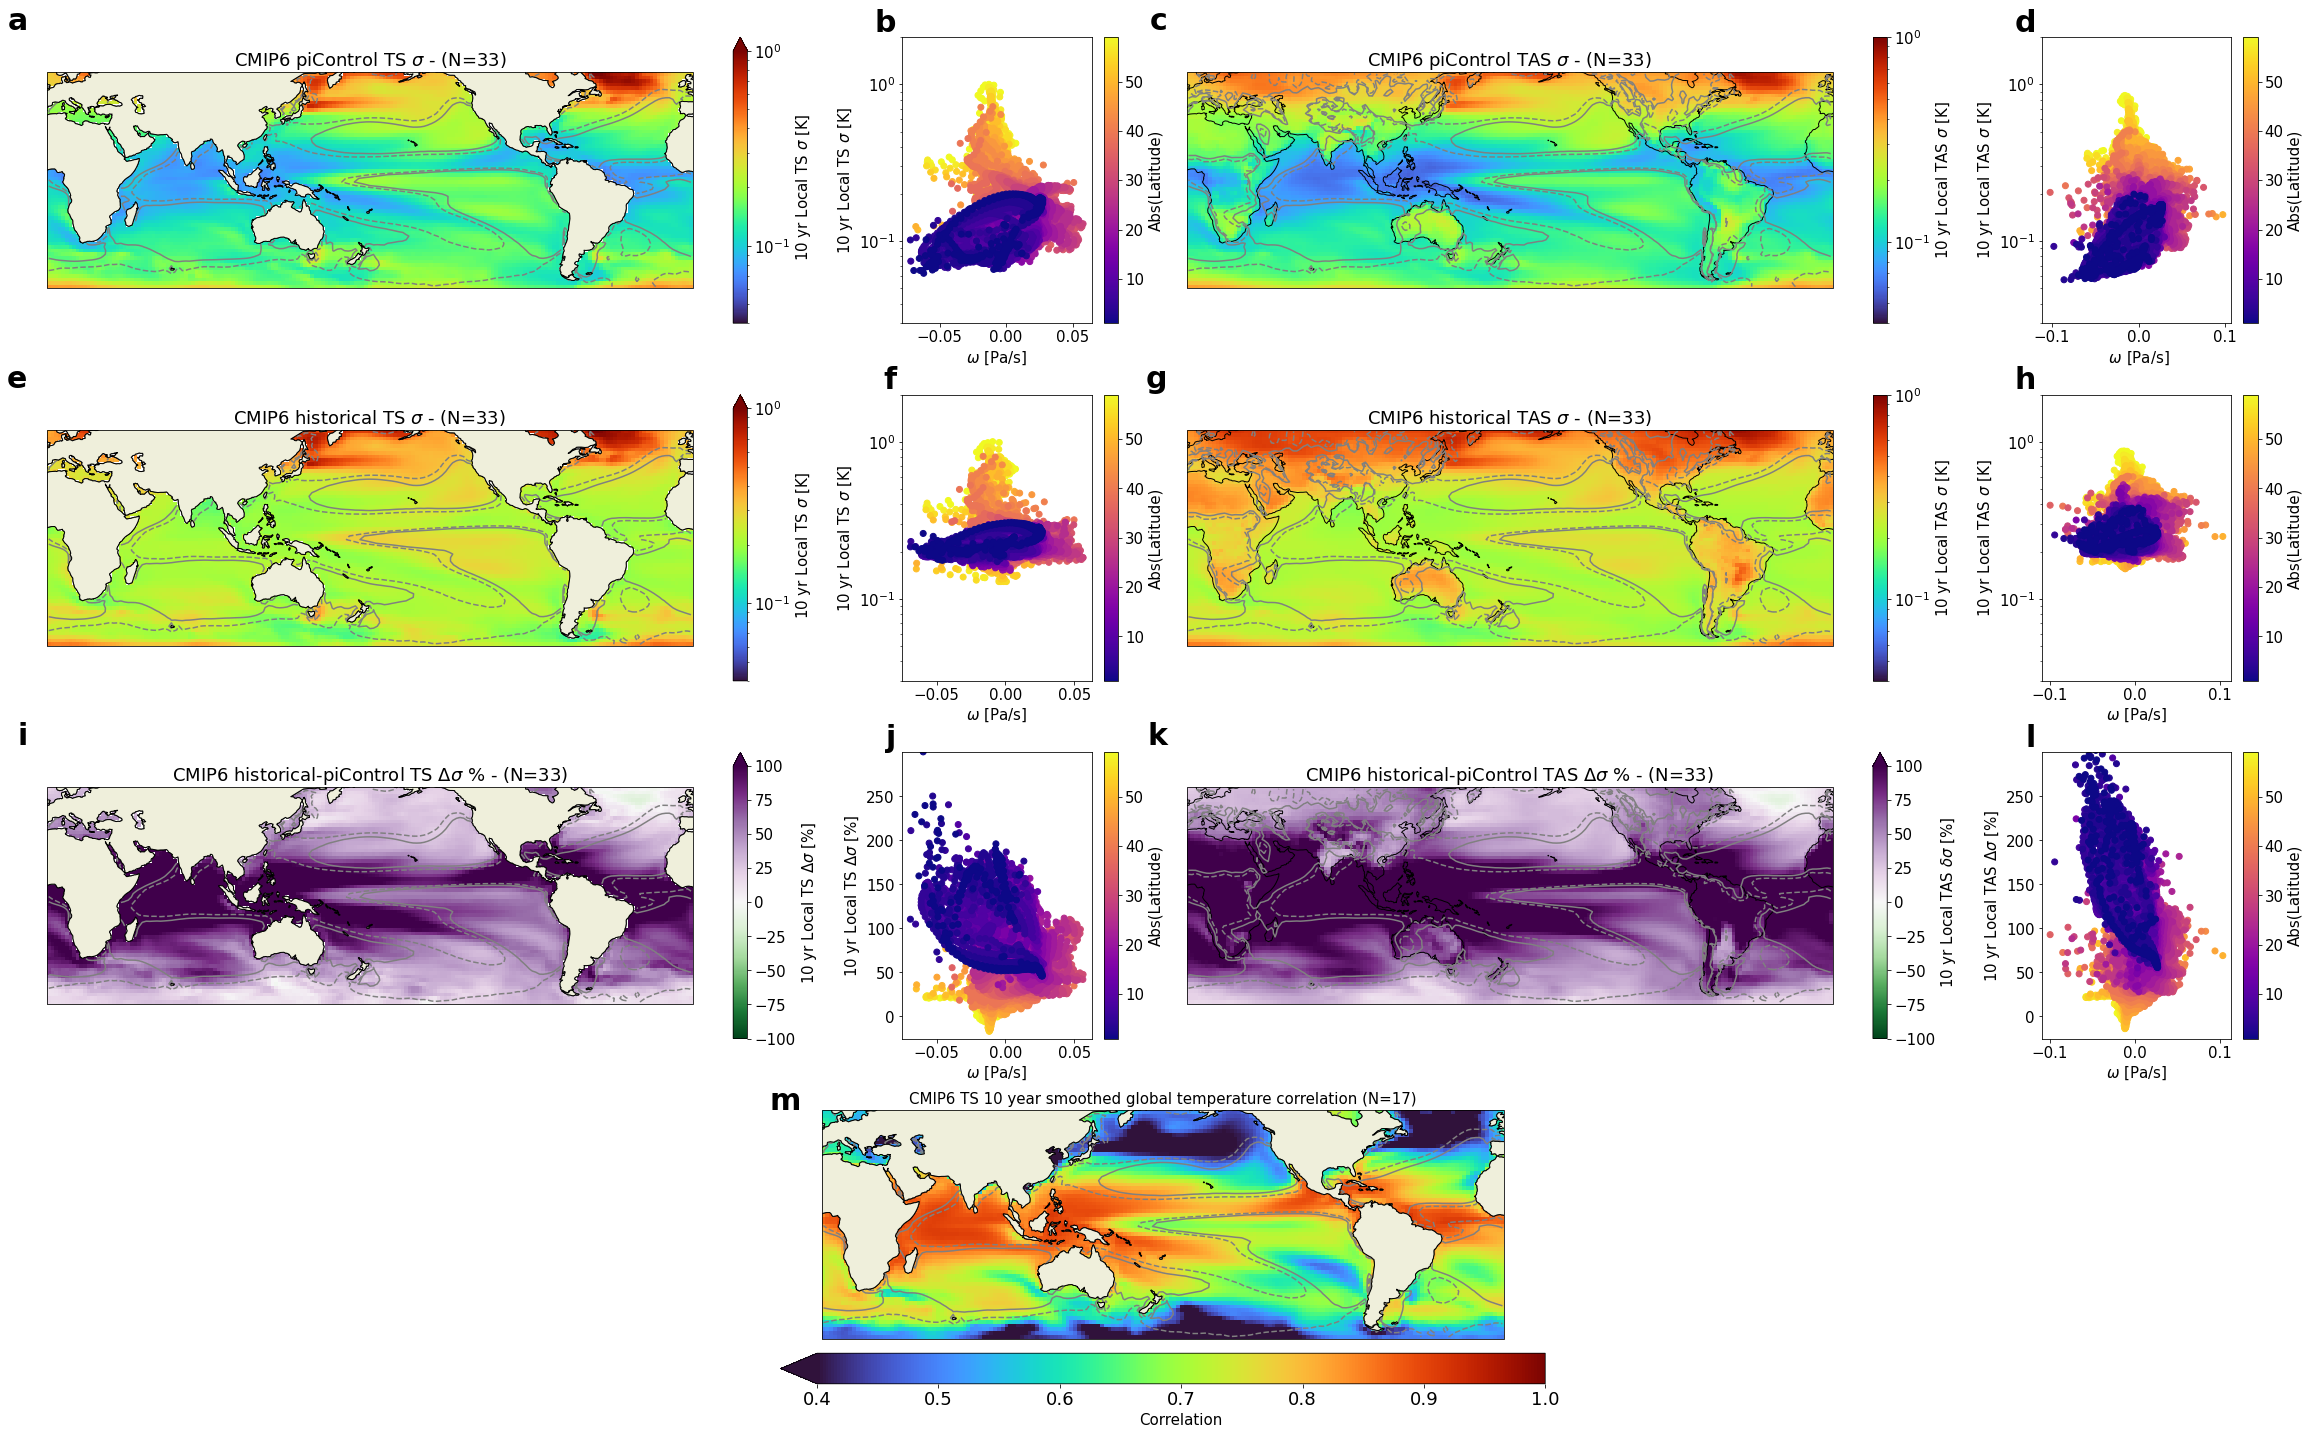

In [67]:
colored_lats = []
for latitude in list(reversed(omega_cont_mask.sel(lat=slice(0,60))['lat'].values)):
    for i in range(179): #length of longitude
       colored_lats.append(abs(latitude))
       colored_lats.append(abs(latitude))
print(len(colored_lats))

fig = plt.figure(figsize=(40,25))
gs = gridspec.GridSpec(ncols=8, nrows=4)
gs.update(wspace=0.2,hspace=0.25)
#top=300
#bottom=270
font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

ax1 = fig.add_subplot(gs[0,0:3], projection=ccrs.PlateCarree(central_longitude=180))
# https://stackoverflow.com/questions/36525825/mask-ocean-or-land-from-data-using-cartopy
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ts_cont_mask.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                  })
ax1.coastlines(color='black', linewidth=1)
omega_cont_mask.plot.contour(ax=ax1, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax1.text(-0.03, 1.3, 'a', transform=ax1.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
ax1.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
plt.title(r'CMIP6 piControl TS $\sigma$ - (N=33)')

ax2 = fig.add_subplot(gs[0,3])
scatter_cont_ts = ax2.scatter(reverse(omega_cont_mask),reverse(ts_cont_mask),c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_cont_ts, ax=ax2)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'piControl TS $\sigma$ vs. piControl $\omega$ - (N=33)')
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.ylabel(r'10 yr Local TS $\sigma$ [K]')
ax2.text(-0.03, 1.1, 'b', transform=ax2.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax3 = fig.add_subplot(gs[0,4:7], projection=ccrs.PlateCarree(central_longitude=180))
# https://stackoverflow.com/questions/36525825/mask-ocean-or-land-from-data-using-cartopy
#ax3.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_cont_var.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  })
ax3.coastlines(color='black', linewidth=1)
omega_cont_mean.plot.contour(ax=ax3, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax3.text(-0.03, 1.3, 'c', transform=ax3.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
plt.title(r'CMIP6 piControl TAS $\sigma$ - (N=33)')

ax4 = fig.add_subplot(gs[0,7])
scatter_cont_tas = ax4.scatter(reverse(omega_cont_mean),reverse(tas_cont_var),c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_cont_tas, ax=ax4)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'piControl TAS $\sigma$ vs. piControl $\omega$ - (N=33)')
plt.xlabel(r' $\omega$ [Pa/s]')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.ylabel(r'10 yr Local TAS $\sigma$ [K]')
ax4.text(-0.03, 1.1, 'd', transform=ax4.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')


ax5 = fig.add_subplot(gs[1,0:3], projection=ccrs.PlateCarree(central_longitude=180))
ts_hist_mask.plot(ax=ax5, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                  })
#ax5.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax5.coastlines(color='black', linewidth=1)
omega_hist_mask.plot.contour(ax=ax5, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical TS $\sigma$ - (N=33)')
ax5.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
ax5.text(-0.03, 1.3, 'e', transform=ax5.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax6 = fig.add_subplot(gs[1,3])
scatter_hist_ts = ax6.scatter(reverse(omega_hist_mask),reverse(ts_hist_mask),c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_hist_ts, ax=ax6)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'historical TS $\sigma$ vs. historical $\omega$ - (N=33)')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TS $\sigma$ [K]')
ax6.text(-0.03, 1.1, 'f', transform=ax6.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax7 = fig.add_subplot(gs[1,4:7], projection=ccrs.PlateCarree(central_longitude=180))
tas_hist_var.plot(ax=ax7, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  })
#ax7.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax7.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax7, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical TAS $\sigma$ - (N=33)')
ax7.text(-0.03, 1.3, 'g', transform=ax7.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax8 = fig.add_subplot(gs[1,7])
scatter_hist_tas = ax8.scatter(reverse(omega_hist_mean),reverse(tas_hist_var),c=colored_lats,cmap='plasma')
cbar = plt.colorbar(scatter_hist_tas, ax=ax8)
cbar.ax.set_ylabel('Abs(Latitude)')
#plt.title(r'historical TAS $\sigma$ vs. historical $\omega$ - (N=33)')
plt.ylim(0.03, 2)
plt.yscale('log')
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TAS $\sigma$ [K]')
ax8.text(-0.03, 1.1, 'h', transform=ax8.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax9 = fig.add_subplot(gs[2,0:3], projection=ccrs.PlateCarree(central_longitude=180))
ts_percent_mask.plot(ax=ax9, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-100, vmax=100, 
                    cbar_kwargs={'label': r"10 yr Local TS $\Delta \sigma$ [%]",
                                 })
#ax9.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax9.coastlines(color='black', linewidth=1)
omega_hist_mask.plot.contour(ax=ax9, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical-piControl TS $\Delta \sigma$ % - (N=33)')
ax9.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
ax9.text(-0.03, 1.3, 'i', transform=ax9.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax10 = fig.add_subplot(gs[2,3])
scatter_percent_ts = ax10.scatter(reverse(omega_hist_mask), reverse(ts_percent_mask), c=colored_lats, cmap='plasma')
cbar = plt.colorbar(scatter_percent_ts, ax=ax10)
cbar.ax.set_ylabel('Abs(Latitude)')
plt.ylim(-25,300)
#plt.title('historical-piControl TS $\Delta \sigma$ % vs. historical $\omega$ - (N=33)', fontsize=30)
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TS $\Delta \sigma$ [%]')
ax10.text(-0.03, 1.1, 'j', transform=ax10.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
ax10.set_yticks([0,50,100,150,200,250])

ax11 = fig.add_subplot(gs[2,4:7], projection=ccrs.PlateCarree(central_longitude=180))
tas_percent_var.plot(ax=ax11, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-100, vmax=100,
                     cbar_kwargs={'label': r"10 yr Local TAS $\delta \sigma$ [%]",
                                  })
#ax11.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax11.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax11, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical-piControl TAS $\Delta \sigma$ % - (N=33)')
ax11.text(-0.03, 1.3, 'k', transform=ax11.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax12 = fig.add_subplot(gs[2,7])
scatter_percent_tas = ax12.scatter(reverse(omega_hist_mean), reverse(tas_percent_var), c=colored_lats, cmap='plasma')
cbar = plt.colorbar(scatter_percent_tas, ax=ax12)
cbar.ax.set_ylabel('Abs(Latitude)')
plt.ylim(-25,300)
#plt.title('historical-piControl TAS $\Delta \sigma$ % vs. historical $\omega$ - (N=33)', fontsize=30)
plt.xlabel(r'$\omega$ [Pa/s]')
plt.ylabel(r'10 yr Local TAS $\Delta \sigma$ [%]')
ax12.text(-0.03, 1.1, 'l', transform=ax12.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
ax12.set_yticks([0,50,100,150,200,250])

ax13 = fig.add_subplot(gs[3,2:6], projection=ccrs.PlateCarree(central_longitude=180))
globb = cmip6_ts_global_corr_mean.plot(ax=ax13, transform=ccrs.PlateCarree(), vmin=0.4, vmax=1, cmap='turbo', 
                                                 add_colorbar=False
                                        #cbar_kwargs={'label': 'Correlation',
                                                #     'orientation': 'horizontal',
                                                #     'shrink': 0.9,
                                                #     'pad': 0.05,
                                                #     'aspect': 25}
                                                )
ax13.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax13, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax13.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
plt.title('CMIP6 TS 10 year smoothed global temperature correlation (N=17)', fontsize=15)                                  
cb = plt.colorbar(globb, orientation="horizontal", pad=0.05, aspect=25, shrink=0.7, extend='min')
ax13.set_extent([0,358,-60,60], crs=ccrs.PlateCarree())
ax13.text(-0.03, 1.1, 'm', transform=ax13.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
cb.set_label(label='Correlation', fontsize=15)
cb.ax.tick_params(labelsize='large')

# Bony Decomposition

In [16]:
def binning(omega,temp_var,mini,maxi,spacing):
    omega_dataset = omega.sel(lat=slice(-30,30)).to_dataset()
        
    bin_edges = np.arange(mini,maxi,spacing)
    print(bin_edges)
    
    
    omega_dataset['temp'] = temp_var.sel(lat=slice(-30,30))
    omega_dataset_stack = omega_dataset.stack(z=('lat','lon'))
    omega_dataset_stack['tags'] = pd.cut(omega_dataset_stack['wap'], bins=bin_edges, labels=bin_edges[:-1])
    omega_dataset_stats = omega_dataset_stack.groupby('tags').groups
    
    var_mean_binned = []
    var_std_binned = []
    for group in omega_dataset_stats:
        var_list = []
        for index in omega_dataset_stats[group]:
            var_list.append(omega_dataset_stack.temp[index].item())
        var_mean_binned.append(np.nanmean(var_list))
        var_std_binned.append(np.nanstd(var_list))

    gkde = stats.gaussian_kde(omega_dataset_stack['wap'][~np.isnan(omega_dataset_stack['wap'])])
    pdf = gkde.evaluate(np.linspace(omega_dataset_stack['wap'].min(), omega_dataset_stack['wap'].max(),200))
    
    return omega_dataset_stack, omega_dataset_stats, var_mean_binned, var_std_binned, pdf

[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02]
[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02]
[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02]
[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02]
[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02]
[-8.00000000e-02 -6.00000000e-02 -4.00000000e-02 -2.00000000e-02
  1.38777878e-17  2.00000000e-02  4.00000000e-02  6.00000000e-02]


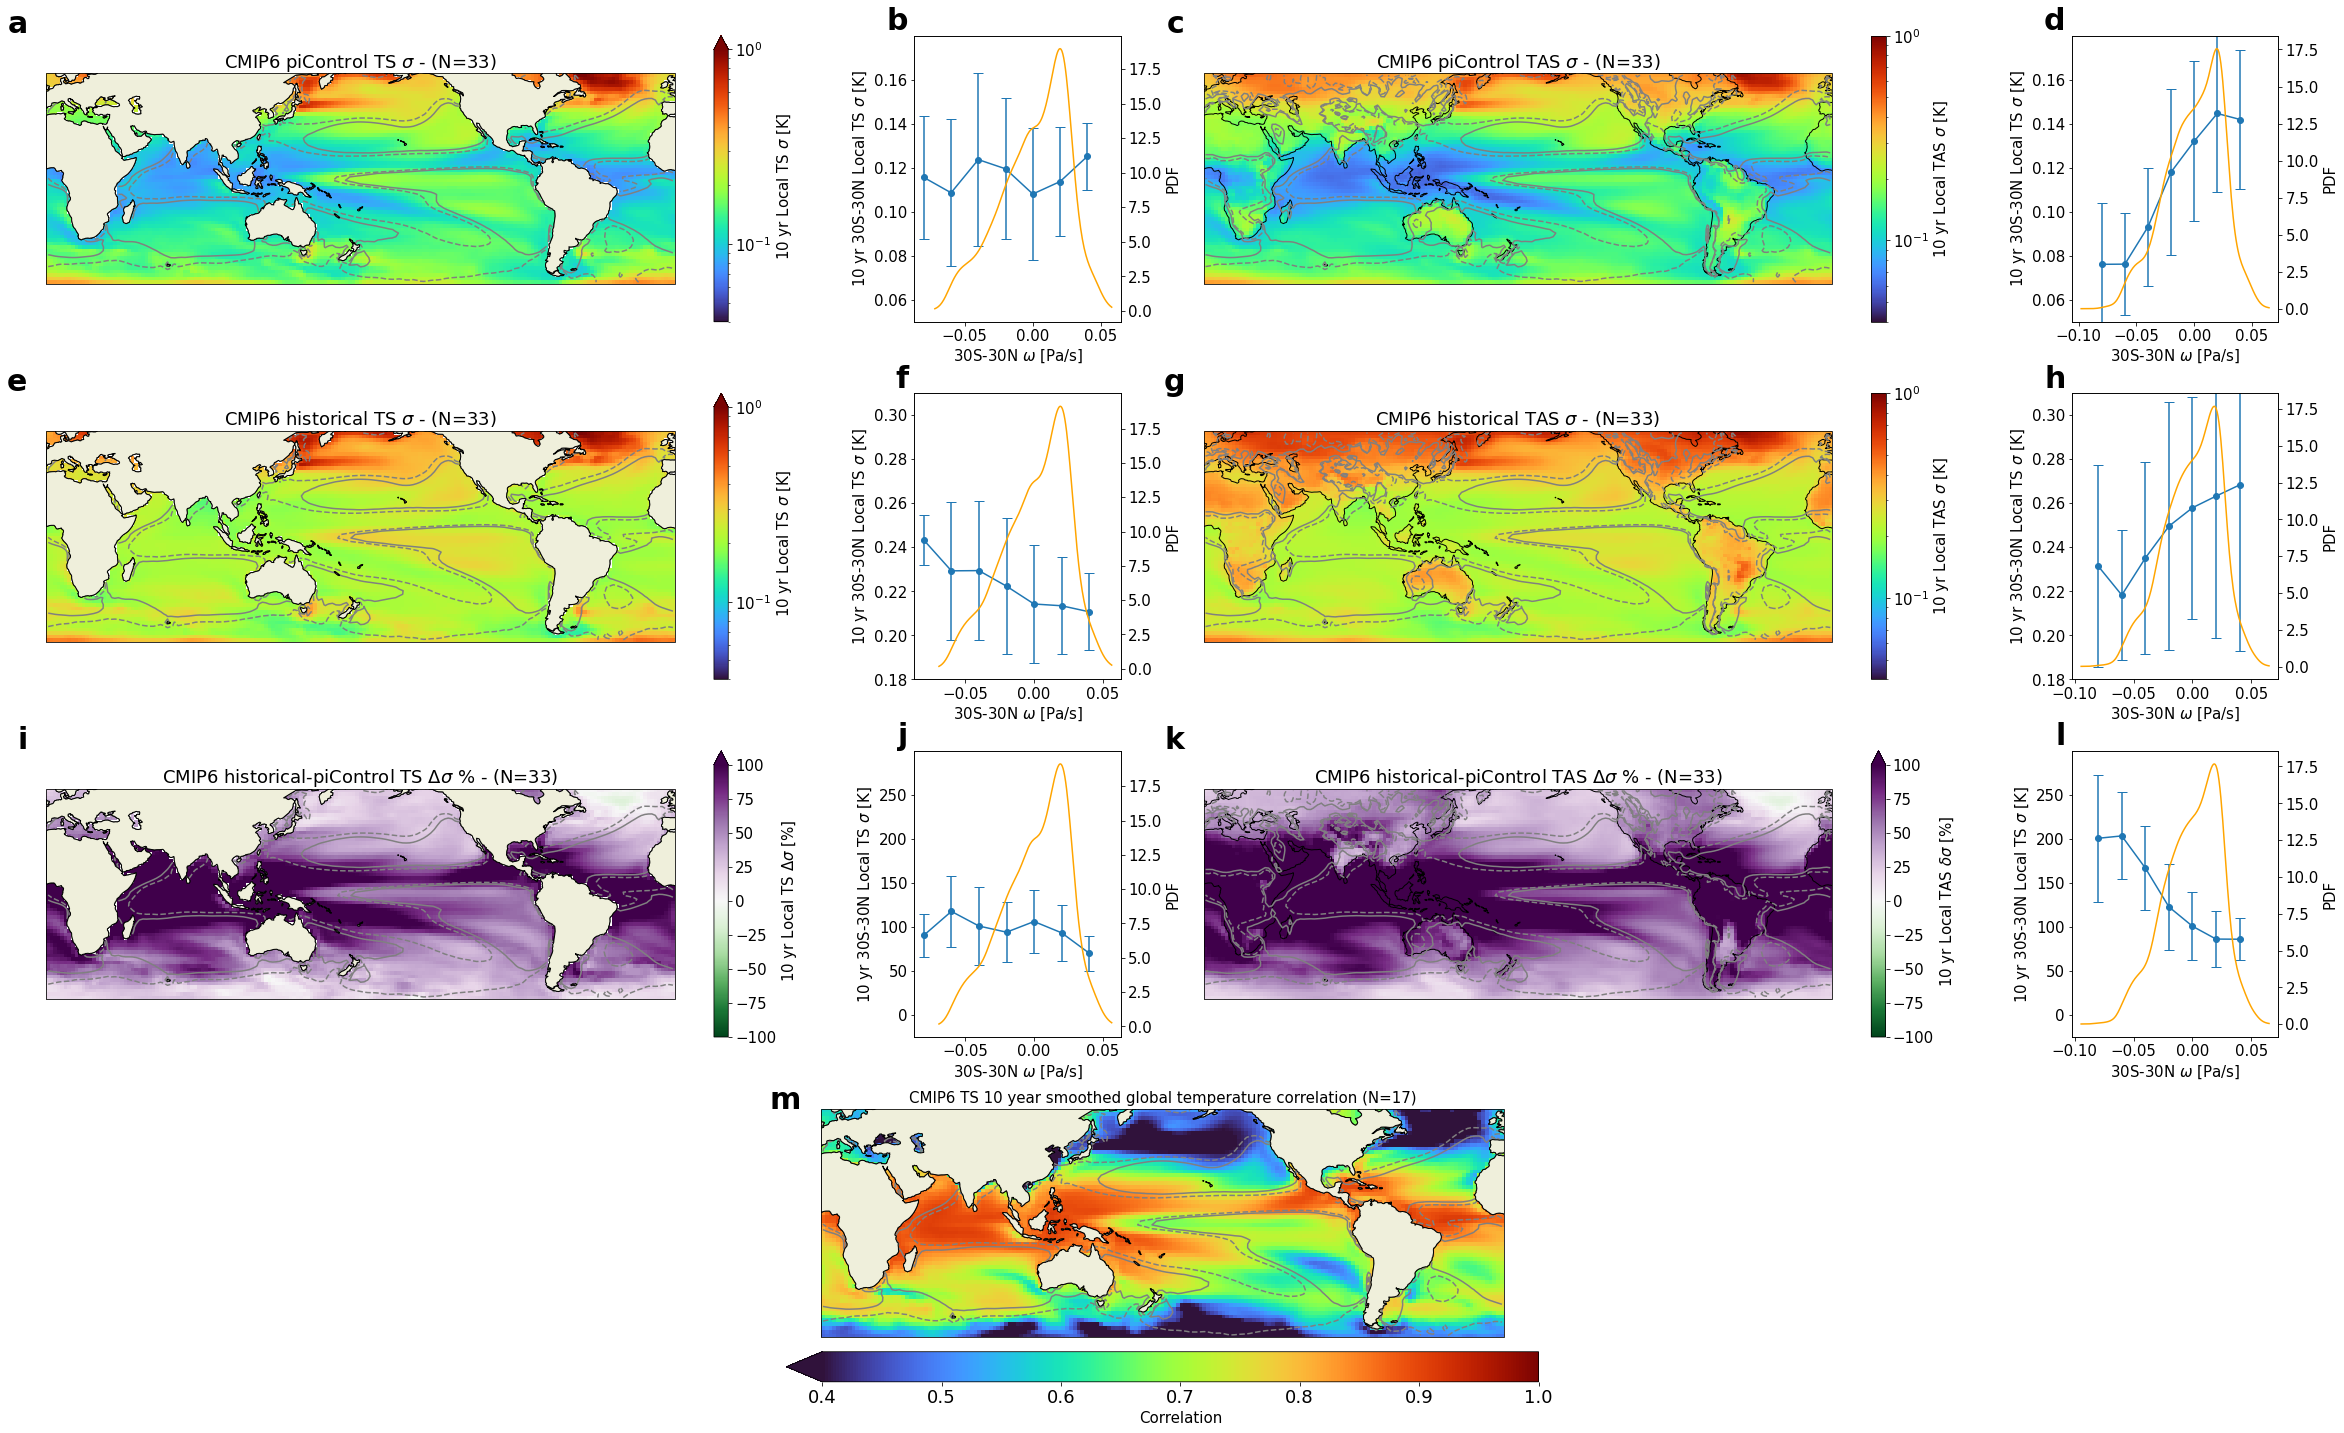

In [34]:
fig = plt.figure(figsize=(40,25))
gs = gridspec.GridSpec(ncols=8, nrows=4)
gs.update(wspace=0.4,hspace=0.25)
#top=300
#bottom=270
font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

ax1 = fig.add_subplot(gs[0,0:3], projection=ccrs.PlateCarree(central_longitude=180))
# https://stackoverflow.com/questions/36525825/mask-ocean-or-land-from-data-using-cartopy
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ts_cont_mask.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                  })
ax1.coastlines(color='black', linewidth=1)
omega_cont_mask.plot.contour(ax=ax1, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax1.text(-0.03, 1.3, 'a', transform=ax1.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
ax1.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
plt.title(r'CMIP6 piControl TS $\sigma$ - (N=33)')

ax2 = fig.add_subplot(gs[0,3])
ts_stack_c, ts_stats_c, ts_m_c, ts_std_c, ts_pdf_c = binning(omega_cont_mask,ts_cont_mask,-0.08,0.08,0.02)
ax2.errorbar(ts_stats_c.keys(), ts_m_c, ts_std_c, capsize=5)
ax2.scatter(ts_stats_c.keys(), ts_m_c)
#plt.title(r'piControl TS $\sigma$ vs. piControl $\omega$ - (N=33)')
ax2.set_xlabel(r'30S-30N $\omega$ [Pa/s]')
ax2.set_ylabel(r'10 yr 30S-30N Local TS $\sigma$ [K]')
ax2.set_ylim(0.05, 0.18)
ax2.set_yticks([0.06,0.08,0.1,0.12,0.14,0.16])
ax2b = ax2.twinx()
ax2b.plot(np.linspace(ts_stack_c['wap'].min(), ts_stack_c['wap'].max(), 200), ts_pdf_c, color='orange')
ax2b.set_ylabel(r'PDF')
ax2b.set_yticks([0,2.5,5,7.5,10,12.5,15,17.5])
ax2.text(-0.03, 1.1, 'b', transform=ax2.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax3 = fig.add_subplot(gs[0,4:7], projection=ccrs.PlateCarree(central_longitude=180))
# https://stackoverflow.com/questions/36525825/mask-ocean-or-land-from-data-using-cartopy
#ax3.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_cont_var.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  })
ax3.coastlines(color='black', linewidth=1)
omega_cont_mean.plot.contour(ax=ax3, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax3.text(-0.03, 1.3, 'c', transform=ax3.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
plt.title(r'CMIP6 piControl TAS $\sigma$ - (N=33)')

ax4 = fig.add_subplot(gs[0,7])
tas_stack_c, tas_stats_c, tas_m_c, tas_std_c, tas_pdf_c = binning(omega_cont_mean,tas_cont_var,-0.08,0.08,0.02)
ax4.errorbar(tas_stats_c.keys(), tas_m_c, tas_std_c, capsize=5)
ax4.scatter(tas_stats_c.keys(), tas_m_c)
ax4.set_xlabel(r'30S-30N $\omega$ [Pa/s]')
ax4.set_ylabel(r'10 yr 30S-30N Local TS $\sigma$ [K]')
ax4.set_ylim(0.05, 0.18)
ax4.set_yticks([0.06,0.08,0.1,0.12,0.14,0.16])
ax4b = ax4.twinx()
ax4b.plot(np.linspace(tas_stack_c['wap'].min(), tas_stack_c['wap'].max(), 200), tas_pdf_c, color='orange')
ax4b.set_ylabel(r'PDF')
ax4.text(-0.03, 1.1, 'd', transform=ax4.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax5 = fig.add_subplot(gs[1,0:3], projection=ccrs.PlateCarree(central_longitude=180))
ts_hist_mask.plot(ax=ax5, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TS $\sigma$ [K]",
                                                                  })
#ax5.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax5.coastlines(color='black', linewidth=1)
omega_hist_mask.plot.contour(ax=ax5, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical TS $\sigma$ - (N=33)')
ax5.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
ax5.text(-0.03, 1.3, 'e', transform=ax5.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax6 = fig.add_subplot(gs[1,3])
ts_stack_h, ts_stats_h, ts_m_h, ts_std_h, ts_pdf_h = binning(omega_hist_mask,ts_hist_mask,-0.08,0.08,0.02)
ax6.errorbar(ts_stats_h.keys(), ts_m_h, ts_std_h, capsize=5)
ax6.scatter(ts_stats_h.keys(), ts_m_h)
ax6.set_xlabel(r'30S-30N $\omega$ [Pa/s]')
ax6.set_ylabel(r'10 yr 30S-30N Local TS $\sigma$ [K]')
ax6.set_ylim(0.18, 0.31)
ax6.set_yticks([0.18,0.20,0.22,0.24,0.26,0.28,0.3])
ax6b = ax6.twinx()
ax6b.plot(np.linspace(ts_stack_h['wap'].min(), ts_stack_h['wap'].max(), 200), ts_pdf_h, color='orange')
ax6b.set_ylabel(r'PDF')
ax6b.set_yticks([0,2.5,5,7.5,10,12.5,15,17.5])
ax6.text(-0.03, 1.1, 'f', transform=ax6.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')


ax7 = fig.add_subplot(gs[1,4:7], projection=ccrs.PlateCarree(central_longitude=180))
tas_hist_var.plot(ax=ax7, transform=ccrs.PlateCarree(), cmap='turbo', vmin=4*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': r"10 yr Local TAS $\sigma$ [K]",
                                                                  })
#ax7.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax7.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax7, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical TAS $\sigma$ - (N=33)')
ax7.text(-0.03, 1.3, 'g', transform=ax7.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax8 = fig.add_subplot(gs[1,7])
tas_stack_h, tas_stats_h, tas_m_h, tas_std_h, tas_pdf_h = binning(omega_hist_mean,tas_hist_var,-0.08,0.08,0.02)
ax8.errorbar(tas_stats_h.keys(), tas_m_h, tas_std_h, capsize=5)
ax8.scatter(tas_stats_h.keys(), tas_m_h)
ax8.set_xlabel(r'30S-30N $\omega$ [Pa/s]')
ax8.set_ylabel(r'10 yr 30S-30N Local TS $\sigma$ [K]')
ax8.set_ylim(0.18, 0.31)
ax8.set_yticks([0.18,0.2,0.22,0.24,0.26,0.28,0.3])
ax8b = ax8.twinx()
ax8b.plot(np.linspace(tas_stack_h['wap'].min(), tas_stack_h['wap'].max(), 200), tas_pdf_h, color='orange')
ax8b.set_ylabel(r'PDF')
ax8.text(-0.03, 1.1, 'h', transform=ax8.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax9 = fig.add_subplot(gs[2,0:3], projection=ccrs.PlateCarree(central_longitude=180))
ts_percent_mask.plot(ax=ax9, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-100, vmax=100, 
                    cbar_kwargs={'label': r"10 yr Local TS $\Delta \sigma$ [%]",
                                 })
#ax9.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax9.coastlines(color='black', linewidth=1)
omega_hist_mask.plot.contour(ax=ax9, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical-piControl TS $\Delta \sigma$ % - (N=33)')
ax9.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
ax9.text(-0.03, 1.3, 'i', transform=ax9.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax10 = fig.add_subplot(gs[2,3])
ts_stack_p, ts_stats_p, ts_m_p, ts_std_p, ts_pdf_p = binning(omega_hist_mask,ts_percent_mask,-0.08,0.08,0.02)
ax10.errorbar(ts_stats_p.keys(), ts_m_p, ts_std_p, capsize=5)
ax10.scatter(ts_stats_p.keys(), ts_m_p)
ax10.set_xlabel(r'30S-30N $\omega$ [Pa/s]')
ax10.set_ylabel(r'10 yr 30S-30N Local TS $\sigma$ [K]')
ax10.set_ylim(-25, 300)
ax10.set_yticks([0,50,100,150,200,250])
ax10b = ax10.twinx()
ax10b.plot(np.linspace(ts_stack_p['wap'].min(), ts_stack_p['wap'].max(), 200), ts_pdf_p, color='orange')
ax10b.set_ylabel(r'PDF')
ax10b.set_yticks([0,2.5,5,7.5,10,12.5,15,17.5])
ax10.text(-0.03, 1.1, 'j', transform=ax10.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax11 = fig.add_subplot(gs[2,4:7], projection=ccrs.PlateCarree(central_longitude=180))
tas_percent_var.plot(ax=ax11, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-100, vmax=100,
                     cbar_kwargs={'label': r"10 yr Local TAS $\delta \sigma$ [%]",
                                  })
#ax11.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
ax11.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax11, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title(r'CMIP6 historical-piControl TAS $\Delta \sigma$ % - (N=33)')
ax11.text(-0.03, 1.3, 'k', transform=ax11.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax12 = fig.add_subplot(gs[2,7])
tas_stack_p, tas_stats_p, tas_m_p, tas_std_p, tas_pdf_p = binning(omega_hist_mean,tas_percent_var,-0.08,0.08,0.02)
ax12.errorbar(tas_stats_p.keys(), tas_m_p, tas_std_p, capsize=5)
ax12.scatter(tas_stats_p.keys(), tas_m_p)
ax12.set_xlabel(r'30S-30N $\omega$ [Pa/s]')
ax12.set_ylabel(r'10 yr 30S-30N Local TS $\sigma$ [K]')
ax12.set_ylim(-25,300)
ax12.set_yticks([0,50,100,150,200,250])
ax12b = ax12.twinx()
ax12b.plot(np.linspace(tas_stack_p['wap'].min(), tas_stack_p['wap'].max(), 200), tas_pdf_p, color='orange')
ax12b.set_ylabel(r'PDF')
ax12.text(-0.03, 1.1, 'l', transform=ax12.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')

ax13 = fig.add_subplot(gs[3,2:6], projection=ccrs.PlateCarree(central_longitude=180))
globb = cmip6_ts_global_corr_mean.plot(ax=ax13, transform=ccrs.PlateCarree(), vmin=0.4, vmax=1, cmap='turbo', 
                                                 add_colorbar=False
                                        #cbar_kwargs={'label': 'Correlation',
                                                #     'orientation': 'horizontal',
                                                #     'shrink': 0.9,
                                                #     'pad': 0.05,
                                                #     'aspect': 25}
                                                )
ax13.coastlines(color='black', linewidth=1)
omega_hist_mean.plot.contour(ax=ax13, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
ax13.add_feature(cart.feature.LAND, zorder=2, edgecolor='k')
plt.title('CMIP6 TS 10 year smoothed global temperature correlation (N=17)', fontsize=15)                                  
cb = plt.colorbar(globb, orientation="horizontal", pad=0.05, aspect=25, shrink=0.7, extend='min')
ax13.set_extent([0,358,-60,60], crs=ccrs.PlateCarree())
ax13.text(-0.03, 1.1, 'm', transform=ax13.transAxes,
      fontsize=30, fontweight='bold', va='top', ha='right')
cb.set_label(label='Correlation', fontsize=15)
cb.ax.tick_params(labelsize='large')

# Testing

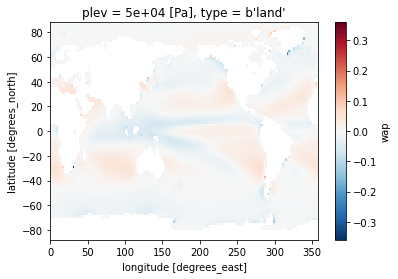

In [11]:
omega_cont_mask.mean('time').mean('name').plot()

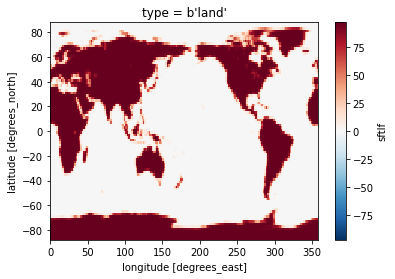

In [3]:
land_mask.mean('name').plot()